In [1]:
import numpy as np
import os, fnmatch
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

result = find('*.jpg', 'lfwfaces')
print("Number of images: " + str(len(result)))
print("Example file name: " + result[0])

Number of images: 13233
Example file name: lfwfaces/Aaron_Eckhart_0001.jpg


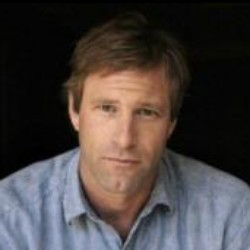

(250, 250, 3)
(254, 254, 3)


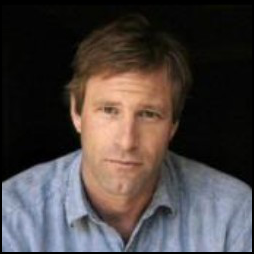

In [3]:
img = load_img(result[0])
display(img)
img = img_to_array(img)
print(img.shape)
padded = np.pad(img, ((2, 2), (2, 2), (0, 0)), 'constant')
print(padded.shape)
padded = array_to_img(padded)
display(padded)

def zero_pad(X, pad):
    
    padded_imgs = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return padded_imgs


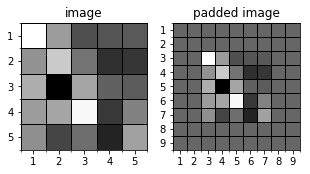

In [4]:
# x = np.random.randn(4, 3, 3, 2)
x = np.random.randn(1, 5, 5, 1)
x_pad = zero_pad(x, 2)

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

fig, axarr = plt.subplots(1, 2)

for i in range(2):

    if i == 0:
        axarr[i].set_title('image')
    else:
        axarr[i].set_title('padded image')

    axarr[i].set_xticks(np.arange(0, 10, 1));
    axarr[i].set_yticks(np.arange(0, 10, 1));
    axarr[i].set_xticklabels(np.arange(1, 11, 1));
    axarr[i].set_yticklabels(np.arange(1, 11, 1));
    axarr[i].set_xticks(np.arange(-.5, 10, 1), minor=True);
    axarr[i].set_yticks(np.arange(-.5, 10, 1), minor=True);
    axarr[i].grid(which='minor', color='black', linestyle='-', linewidth=1)

    if i == 0:
        axarr[i].imshow(x[0,:,:,0])
    else:
        axarr[i].imshow(x_pad[0,:,:,0])

In [5]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(9.0).reshape((3, 3))
x2 = x2 + 1
print(x1)
print(x2)
print(np.multiply(x1, x2))
print(np.multiply(x1, x2) - 1)

def conv_single_step(a_slice_prev, W, b):
    
    convolved = np.multiply(a_slice_prev, W) + b
    summation = np.sum(convolved)
    return summation


[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[ 0.  2.  6.]
 [12. 20. 30.]
 [42. 56. 72.]]
[[-1.  1.  5.]
 [11. 19. 29.]
 [41. 55. 71.]]


In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    # Retrieve dimensions from A_prev's shape (≈1 line) 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + (2 * pad)) / stride) + 1
    n_W = int((n_W_prev - f + (2 * pad)) / stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    # Convolve
    for i in range(m):                                 # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                     # Select ith training example's padded activation
        
        for h in range(n_H):                           # loop over vertical axis of the output volume
            
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
    
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache